# Haystack Pipelines

Install:\
%pip install haystack-ai\
%pip install python-pptx\
%pip install python-docx\
%pip install pypdf\
%pip install trafilatura\
%pip install unstructured-client\
%pip install unstructured-fileconverter-haystack\
%pip install unstructured\
%pip install tika\
%pip install sentence-transformers>=2.3.0

# Prompt Templates & Queries/Instructions

In [2]:
# Prompt templates
text_template = """
You are a technical writer tasked with updating an outdated user guide for a product/service.
Your task is to update an outdated user guide by incorporating relevant information from the provided reference material.
Only generate the content that is to be used in this updated user guide.
Do not provide explanations or notes.

Given the following information, complete the task.

Outdated User Guide: {{ documents[0].content }}
Reference Material: {{ documents[1].content }}

Task: {{ query }}?
"""

slides_template = """
You are an assistant tasked with generating JSON data required by the user for creating slides.
Your task is to generate only the JSON data based on the updated content provided.
Do not include any additional text or explanations.

Context:
Updated Content:
{% for doc in documents %}
    {% if doc.meta['name'] == 'updated' %}
        {{ doc.content }}
    {% endif %}
{% endfor %}

Task: {{ query }}?
"""

script_template = """
You are a skilled scriptwriter tasked with crafting a clear, engaging, professional, and conversational script intended for a corporate training video. Your role is to create content that is simple and accessible, while ensuring the instructional integrity of the material. As you write, focus on maintaining a friendly yet authoritative tone. Ensure that the final output is polished and suitable for direct reading by a text-to-speech (TTS) model. Remove any bracketed text, stage directions, or any content that would not be read directly from the script. The output should not include introductory phrases or descriptions of the script content.

Context:
Updated Content:
{% for doc in documents %}
    {% if doc.meta['name'] == 'updated' %}
        {{ doc.content }}
    {% endif %}
{% endfor %}

Task: {{ query }}?
"""

# Queries
text_query = """
Update an outdated user guide by incorporating relevant information from the provided reference material.
"""
slides_query = """
Generate a 10 slide presentation for the user guide.
"""

script_query = """
Generate a polished script for a corporate training video based on the updated content. Ensure the script is clear, engaging, and professional, and is suitable for direct reading by a text-to-speech (TTS) voice. Exclude any introductory phrases or descriptions, and remove content that is not meant for direct reading.
"""

# Generate Text for Documents, Slides and TTS Script

In [3]:
from haystack import Pipeline
from haystack.components.retrievers.in_memory import InMemoryBM25Retriever
from haystack.components.builders.prompt_builder import PromptBuilder
from haystack.components.generators import OpenAIGenerator
from haystack.document_stores.in_memory import InMemoryDocumentStore
from haystack import Document
from haystack.components.converters.txt import TextFileToDocument
from haystack.utils import Secret
import os

Preprocessing step: Load files and convert them to Documents, a Haystack data class.

https://docs.haystack.deepset.ai/docs/data-classes#document

In [4]:
# Convert .txt to Document object (not .docx)
converter = TextFileToDocument()
results = converter.run(sources=["reference.txt", "outdated.txt"])

# Add Documents to the InMemoryDocumentStore
documents = results["documents"]
docstore = InMemoryDocumentStore()
docstore.write_documents([Document(content=documents[0].content), Document(content=documents[1].content)])

Create an LLM component for inference

In [6]:
os.environ["GROQ_OPENAI_API_KEY"]="<GROQ_API_KEY>" # Replace with your Groq API key
api_key=os.getenv("GROQ_OPENAI_API_KEY")

def llm_component(temp):
    return OpenAIGenerator(
        api_key=Secret.from_env_var("GROQ_OPENAI_API_KEY"),
        api_base_url="https://api.groq.com/openai/v1",
        model="llama3-8b-8192", # Llama 3 - Groq Model
        generation_kwargs={"temperature": temp}  # TEMP 0.2 "n":2
    )

Create a query pipeline where each component's output becomes the input for the next.

In [ ]:
# Pipeline function for generating text for training material, user guides, powerpoint data(JSON), and TTS script
def inference_pipeline(query, template, docstore, temp=0.2):
    llm = llm_component(temp)
    pipe = Pipeline()
    pipe.add_component("retriever", InMemoryBM25Retriever(document_store=docstore))
    pipe.add_component("prompt_builder", PromptBuilder(template=template))
    pipe.add_component("llm", llm)
    pipe.connect("retriever", "prompt_builder.documents") # prompt_builder component will take the content
    pipe.connect("prompt_builder", "llm")

    res = pipe.run({"retriever": {"query": query},"prompt_builder": {"query": query}})

    # Returns the LLM generated response
    return res['llm']['replies'][0]

### inference_pipeline Graph
1. **Retriever Component**: The retriever fetches documents from the document_store based on the input query.
2. **Connecting to PromptBuilder**: The retrieved documents are passed to the PromptBuilder via the documents input.
3. **PromptBuilder Component**: The PromptBuilder uses these documents and the specified template to build a structured prompt.
4. **LLM Inference**: The prompt is sent to the llm component for inference.

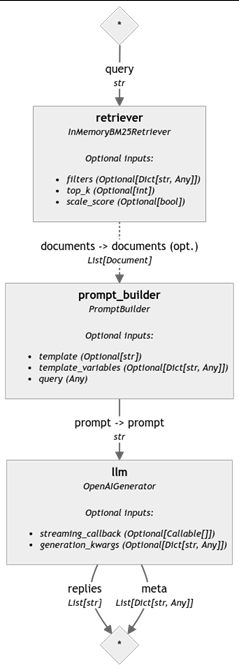

### Run the Pipeline to generate text

In [7]:
# Text for User Guides & Training Manuals

# Call inference_pipline function
generate_text = inference_pipeline(text_query, text_template, docstore) # Pass query and prompt template
print(generate_text)

 # Store the response in the document store. You would only do this if you want to generate content(guides, slides, and scripts) from outdated and reference.
documents = str(generate_text)
docstore.write_documents([Document(content=documents, meta={"name": "updated"})])

### Creating Text for Slides

In [8]:
# Text for Slides

generate_slides = inference_pipeline(slides_query, slides_template, docstore, temp=0.5)
print(generate_slides)

### Creating Text for Text-to-Speech Scripts

In [9]:
# Text for text-to-speech Script

generate_script = inference_pipeline(script_query, script_template, docstore, temp=0.6)
print(generate_script)

# Creating Indexing Pipeline
**The FileTypeRouter selects the appropriate converter based on the uploaded file type.**

Indexing for the following file types:

* TXT (https://docs.haystack.deepset.ai/reference/converters-api#textfiletodocument)
* DOCX (https://docs.haystack.deepset.ai/reference/converters-api#docxtodocument)
* PDF (https://docs.haystack.deepset.ai/reference/converters-api#module-pypdf)
* PPTX (https://docs.haystack.deepset.ai/reference/converters-api#module-pptx)

FileTypeRouter mime_types

- https://developer.mozilla.org/en-US/docs/Web/HTTP/Basics_of_HTTP/MIME_types/Common_types

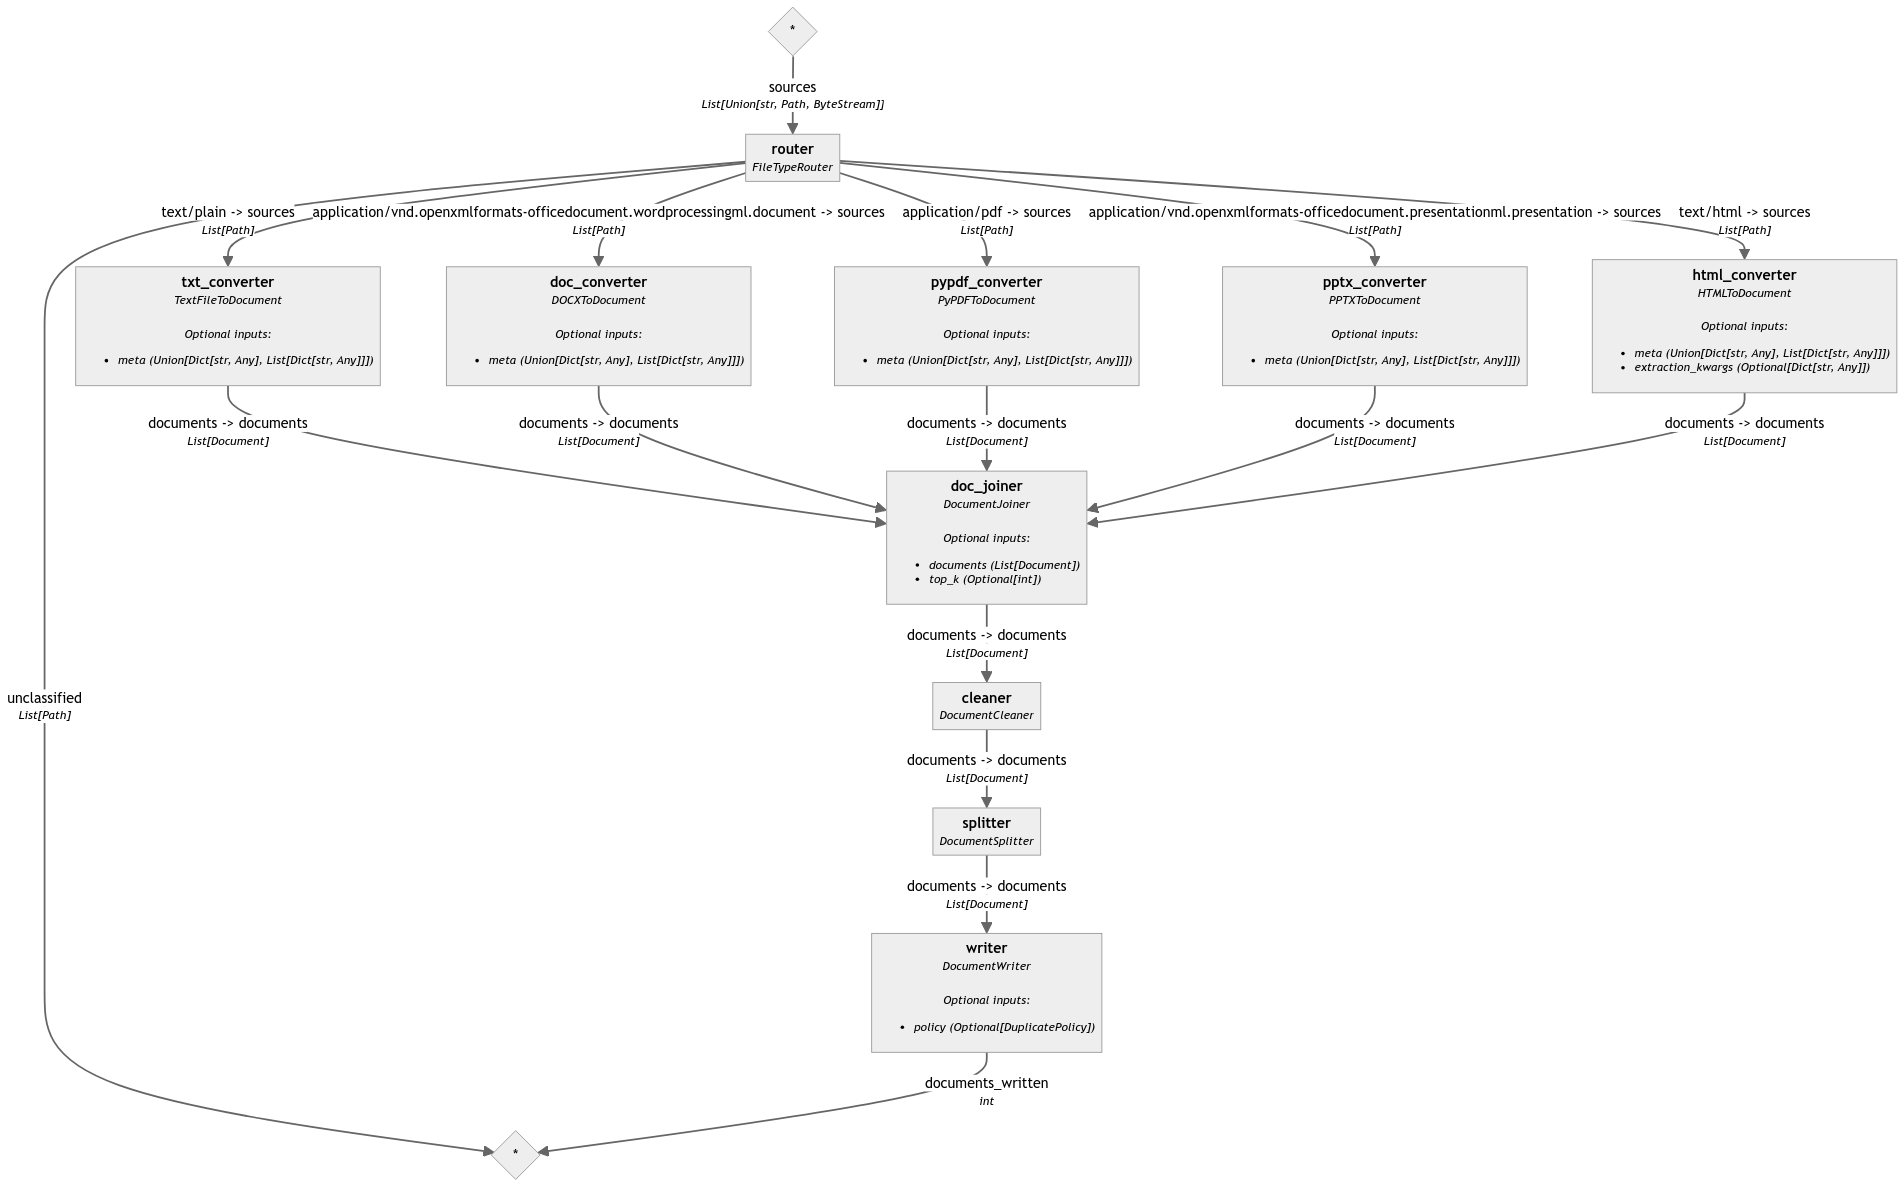

In [10]:
from haystack.components.writers import DocumentWriter
from haystack.components.converters import MarkdownToDocument, PyPDFToDocument, TextFileToDocument, DOCXToDocument, PPTXToDocument, HTMLToDocument
from haystack.components.preprocessors import DocumentSplitter, DocumentCleaner
from haystack.components.fetchers import LinkContentFetcher
from haystack.components.routers import FileTypeRouter
from haystack.components.joiners import DocumentJoiner
from haystack.components.embedders import SentenceTransformersDocumentEmbedder
from haystack import Pipeline
from haystack.document_stores.in_memory import InMemoryDocumentStore

document_store = InMemoryDocumentStore()

In [11]:
def indexing_pipeline(uploaded_file):
  pipeline = Pipeline()
  pipeline.add_component("router", FileTypeRouter(
      mime_types=[
          "text/plain",
          "application/pdf",
          "application/vnd.openxmlformats-officedocument.wordprocessingml.document",
          "application/vnd.openxmlformats-officedocument.presentationml.presentation",
          "text/html"]))
  pipeline.add_component("txt_converter", TextFileToDocument())
  pipeline.add_component("doc_converter", DOCXToDocument())
  pipeline.add_component("pypdf_converter", PyPDFToDocument())
  pipeline.add_component("pptx_converter", PPTXToDocument())
  pipeline.add_component("html_converter", HTMLToDocument())
  pipeline.add_component("doc_joiner", DocumentJoiner())
  pipeline.add_component("cleaner", DocumentCleaner())
  pipeline.add_component("splitter", DocumentSplitter(split_by="word", split_length=150, split_overlap=50))
  pipeline.add_component("writer", DocumentWriter(document_store=document_store))

  pipeline.connect("router.text/plain", "txt_converter.sources")
  pipeline.connect("router.application/vnd.openxmlformats-officedocument.wordprocessingml.document", "doc_converter.sources")
  pipeline.connect("router.application/pdf", "pypdf_converter.sources")
  pipeline.connect("router.application/vnd.openxmlformats-officedocument.presentationml.presentation", "pptx_converter.sources")
  pipeline.connect("router.text/html", "html_converter.sources")
  pipeline.connect("txt_converter", "doc_joiner")
  pipeline.connect("doc_converter", "doc_joiner")
  pipeline.connect("pypdf_converter", "doc_joiner")
  pipeline.connect("pptx_converter", "doc_joiner")
  pipeline.connect("html_converter", "doc_joiner")
  pipeline.connect("doc_joiner", "cleaner")
  pipeline.connect("cleaner", "splitter")
  pipeline.connect("splitter", "writer")
  # pipeline.show()
  return pipeline.run({"router": {"sources": uploaded_file}})

uploaded_file=["outdated_user_guide.txt","outdated_user_guide.docx","presentation.pptx","outdated_user_guide.pdf"]


### DEMO: Search each index with the context(query) "outdated" and display the results.

In [12]:
from haystack.components.retrievers.in_memory import InMemoryBM25Retriever

# Search and Display
for file in uploaded_file:
  indexing_pipeline([file])
  retriever = InMemoryBM25Retriever(document_store)
  result = retriever.run(query="outdated")

for r in result["documents"]:
    print(r.content + "\n")

# Indexing Pipeline for URLs

Since the pipeline lacks a splitter component, the retriever will return the entire content of the entire document.

In [13]:
from haystack import Pipeline
from haystack.document_stores.in_memory import InMemoryDocumentStore
from haystack.components.fetchers import LinkContentFetcher
from haystack.components.converters import HTMLToDocument
from haystack.components.writers import DocumentWriter
from haystack.components.retrievers.in_memory import InMemoryBM25Retriever

document_store = InMemoryDocumentStore()

# Creating the indexing pipeline for website URLs
def url_indexing_pipeline(url):
  pipeline = Pipeline()
  pipeline.add_component("fetcher", LinkContentFetcher())
  pipeline.add_component("converter", HTMLToDocument())
  pipeline.add_component("writer", DocumentWriter(document_store = document_store))

  pipeline.connect("fetcher.streams", "converter.sources")
  pipeline.connect("converter.documents", "writer.documents")
  pipeline.show()
  pipeline.run(data={"fetcher": {"urls": url}})

# This will be a file that the user uploads
uploaded_file=["https://docs.haystack.deepset.ai/reference/data-classes-api"]

# Retrieve content
for file in uploaded_file:
  url_indexing_pipeline([file])
  retriever = InMemoryBM25Retriever(document_store)
  result = retriever.run(query="data classes")

 # Display retrieved content
for r in result["documents"]:
    print(r.content + "\n")

# Tika Converter
We can process various file types using the TikaDocumentConverter component, removing the need for the FileTypeRouter. It can not process URLs—the pipeline above will handle URLs.

https://docs.haystack.deepset.ai/docs/tikadocumentconverter

In [14]:
from haystack import Pipeline
from haystack.document_stores.in_memory import InMemoryDocumentStore
from haystack.components.converters import TikaDocumentConverter
from haystack.components.preprocessors import DocumentCleaner
from haystack.components.preprocessors import DocumentSplitter
from haystack.components.writers import DocumentWriter
from haystack.components.retrievers.in_memory import InMemoryBM25Retriever
from haystack.core import component

In [15]:
# Initialize document store
document_store = InMemoryDocumentStore()

In [16]:
# Pipeline function for converting, cleaning, splitting/chunking, and storing text from various file types
def indexing_pipeline(uploaded_file):
    pipeline = Pipeline()
    pipeline.add_component("converter", TikaDocumentConverter())
    pipeline.add_component("cleaner", DocumentCleaner())
    # pipeline.add_component("splitter", DocumentSplitter(split_by="passage", split_length=5))
    pipeline.add_component("splitter", DocumentSplitter(split_by="sentence", split_length=5))
    # pipeline.add_component("splitter", DocumentSplitter(split_by="page", split_length=5))
    pipeline.add_component("writer", DocumentWriter(document_store=document_store))
    pipeline.connect("converter", "cleaner")
    pipeline.connect("cleaner", "splitter")
    pipeline.connect("splitter", "writer")
    pipeline.show()
    pipeline.run({"converter": {"sources": uploaded_file}})

# uploaded_file=["outdated_user_guide.docx"]

uploaded_file=[
    # "outdated_user_guide.txt",
    # "outdated_user_guide.docx",
    "outdated_user_guide.pdf"]


In [17]:
from haystack.components.retrievers.in_memory import InMemoryBM25Retriever

# Search and Display
for file in uploaded_file:
  indexing_pipeline([file])
  retriever = InMemoryBM25Retriever(document_store)
  result = retriever.run(query="outdated")

for r in result["documents"]:
    print(r.content + "\n")

# UnstructuredFileConverter
The UnstructuredFileConverter allows indexing one page at a time, which is particularly useful for PPTX files.

In [22]:
import os
from haystack import Pipeline
from haystack.components.writers import DocumentWriter
from haystack.document_stores.in_memory import InMemoryDocumentStore
from haystack_integrations.components.converters.unstructured import UnstructuredFileConverter
from haystack.components.retrievers.in_memory import InMemoryBM25Retriever
from google.colab import userdata

# Unstructured API Key
UNSTRUCTURED_API_KEY = userdata.get('UNSTRUCTURED_API_KEY')
os.environ['UNSTRUCTURED_API_KEY'] = UNSTRUCTURED_API_KEY

document_store = InMemoryDocumentStore()

indexing = Pipeline()
indexing.add_component("converter", UnstructuredFileConverter(document_creation_mode="one-doc-per-page"))
indexing.add_component("writer", DocumentWriter(document_store))
indexing.connect("converter", "writer")

indexing.run({"converter": {"paths": ["presentation.pptx"]}})

In [23]:
retriever = InMemoryBM25Retriever(document_store=document_store)
result = retriever.run(query="artificial intelligence")

for i, document in enumerate(result["documents"], start=1):
    print(f"{i}. {document.content}")